## Imports and EDA

In [11]:
# Import libraries

import csv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Define header names

headers = ['age', 'sex','chest_pain','resting_blood_pressure',  
        'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results',
        'max_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',"slope of the peak",
        'num_of_major_vessels','thal', 'heart_disease']

# Make DF

heart_df = pd.read_csv('heart.dat', sep = ' ', names = headers)

In [7]:
# Check shape of DF
heart_df.shape

(270, 14)

In [8]:
# Check for na's

heart_df.isna().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ecg_results        0
max_heart_rate_achieved    0
exercise_induced_angina    0
oldpeak                    0
slope of the peak          0
num_of_major_vessels       0
thal                       0
heart_disease              0
dtype: int64

In [10]:
# Check datatypes

heart_df.dtypes

age                        float64
sex                        float64
chest_pain                 float64
resting_blood_pressure     float64
serum_cholestoral          float64
fasting_blood_sugar        float64
resting_ecg_results        float64
max_heart_rate_achieved    float64
exercise_induced_angina    float64
oldpeak                    float64
slope of the peak          float64
num_of_major_vessels       float64
thal                       float64
heart_disease                int64
dtype: object

In [15]:
# Define training set

X = heart_df.drop(columns = ['heart_disease'])

# Enumerate target class i.e. labels
heart_df['heart_disease'] = heart_df['heart_disease'].replace(1,0)
heart_df['heart_disease'] = heart_df['heart_disease'].replace(2,1)

y_label = heart_df['heart_disease'].values.reshape(X.shape[0], 1)

# Make train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.2, random_state = 2)

In [17]:
# Scale values

sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (216, 13)
Shape of test set is (54, 13)
Shape of train label is (216, 1)
Shape of test labels is (54, 1)


## Define Neural Net

In [52]:
class NeuralNet():
    '''
    Two layer neural network
    '''
    
    def __init__(self, layers = [13, 8, 1], learning_rate = 0.001, epochs = 500):
        self.params = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
        
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1])
        self.params['b1'] = np.random.randn(self.layers[1])
        self.params['W2'] = np.random.randn(self.layers[1], self.layers[2])
        self.params['b2'] = np.random.randn(self.layers[2])
        
    def relu(self, Z):
        '''
        ReLU activation function, threshold operation where values < 0 = 0
        '''
        return np.maximum(0,Z)
    
    def sigmoid(self, Z):
        '''
        Sigmoid activation function
        '''
        return 1/(1 + np.exp(-Z))
    
    def eta(self, x):
        '''
        Function to handle 0 values
        '''
        ETA = 0.0000000001
        return np.maximum(x, ETA)
    
    def cross_entropy(self, y, yhat):
        '''
        Cross entropy loss function guaranteed to converge
        '''
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        yinv = 1.0 - y
        yhat = self.eta(yhat) # clips values to avoid NaN's in log function
        yhat_inv = self.eta(yhat_inv)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((yinv), np.log(yhat_inv))))
        return loss
    
    def forward_propagation(self):
        '''
        1. Compute weighted sum between input and first layer's weights and then adds the bias: Z1 = (W1*X) + b
        2. Pass result through ReLU activation function: A1 = ReLU(Z1)
        3. Compute output function by passing the result through the sigmoid function: A2 = sigmoid(Z2)
        4. Compute the loss between the predicted output and the true labels: loss(A2, Y)
        '''
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.cross_entropy(self.y, yhat)
        
        # Save calculated parameters:
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1
        
        return yhat, loss
    
    def drelu(self, Z):
        Z[Z <= 0] = 0
        Z[Z > 0] = 1
        return Z
    
    def backward_propagation(self, yhat):
        '''
        Calculates the derivatives of respective functions and updates the weights
        '''
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat
        
        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * yhat_inv
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig
        
        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis = 0, keepdims = True)
        
        dl_wrt_z1 = dl_wrt_A1 * self.drelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis = 0, keepdims = True)
        
        #update the weights and biases
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2
    
    def fit(self, X, y):
        '''
        Trains the neural network using specified data + labels
        '''
        self.X = X
        self.y = y
        self.init_weights() # initialize weights and biases
        
        #Train neural network using certain number of epochs
        for i in range(self.epochs):
            yhat, loss = self.forward_propagation()
            self.backward_propagation(yhat)
            self.loss.append(loss)
            print("Training epoch {}, calculated loss: {}".format(i, loss))
            
    def predict(self, X):
        '''
        Makes predictions on test dataset
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)
    
    def accuracy(self, y, yhat):
        '''
        Calculates the accuracy between predicted value and true labels
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc
    
    def plot_loss(self):
        '''
        Plots a loss curve
        '''
        
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("Loss Curve for Training")
        plt.show()

In [55]:
nn = NeuralNet(epochs=50)

In [56]:
nn.fit(Xtrain, ytrain)

Training epoch 0, calculated loss: 1.0072659999619482
Training epoch 1, calculated loss: 0.6904997757203595
Training epoch 2, calculated loss: 0.49898087022218157
Training epoch 3, calculated loss: 0.3771028160333723
Training epoch 4, calculated loss: 0.2955312587168587
Training epoch 5, calculated loss: 0.23871501410430418
Training epoch 6, calculated loss: 0.19770785068659694
Training epoch 7, calculated loss: 0.16729960492522436
Training epoch 8, calculated loss: 0.14421158780645252
Training epoch 9, calculated loss: 0.12669914033457857
Training epoch 10, calculated loss: 0.11308843439752954
Training epoch 11, calculated loss: 0.10222673090743531
Training epoch 12, calculated loss: 0.09341376054889734
Training epoch 13, calculated loss: 0.0861800858864564
Training epoch 14, calculated loss: 0.0800692959067853
Training epoch 15, calculated loss: 0.07484117508756252
Training epoch 16, calculated loss: 0.07031659646416918
Training epoch 17, calculated loss: 0.0663560310251815
Training 

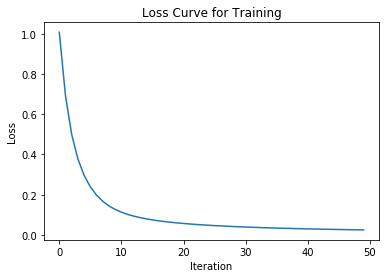

In [57]:
nn.plot_loss()

In [58]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)

In [59]:
print("Train accuracy is {}".format(nn.accuracy(ytrain, train_pred)))
print("Test accuracy is {}".format(nn.accuracy(ytest, test_pred)))

Train accuracy is 100
Test accuracy is 100
